In this notebook, we look into all the halos that TANGOS claims to have "survived" the tidal disruption of the host galaxy Tempest. We are going to perform a bunch of analyses on the "surviving" halos (i.e. virial mass, distance to Tempest, etc.) and then check to see if which halos can be confidently said to contain stars after their survival.

The plots saved by this notebook are called "LDB", which stands for "large database".

In [1]:
import h5py
import tangos as db
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import random

In [2]:
db.all_simulations()

[<Simulation("Tempest.9f11c.all.DD")>]

In [3]:
sim = db.get_simulation('Tempest.9f11c.all.DD')

In [4]:
sats = sim[-1][1].calculate('Satellites()')
print(sats)

[<Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_87' | NDM=110 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_54' | NDM=171 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_21' | NDM=517 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_109' | NDM=84 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_50' | NDM=183 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_12' | NDM=1357 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_115' | NDM=78 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_118' | NDM=75 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_99' | NDM=96 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_73' | NDM=139 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_100' | NDM=96 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_51' | NDM=182 Nstar=0 Ngas=0>
 <Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_113' | NDM=82 Ns

In [5]:
i = 0

all_sat_t = []
all_sat_r = []
all_sat_ratio = []
all_sat_mvir = []
all_sat_mvir_ratio = []
all_sat_mvir_max = []
all_host_rvir = []

while i < np.size(sats):
    
    # this finds the index of each of the satellite halos
    sat_idx = sats[i].halo_number
    
    # this finds the index of the host for each of the satellite halos. the index should be
    # the same for all haloes, but this is coded separately to account for the case where
    # the host halo changes index as its mass profile evolves.
    
    host = sats[i].calculate('Hosts()')
    host_idx = host[0].halo_number
            
    # this uses pre-coded tangos stuff to get M_vir and distance measurements at all available redshifts
    host_rvir, host_mvir, host_x, host_y, host_z, host_t = \
                        sim[-1][host_idx].calculate_for_progenitors('Rvir', 'Mvir', 'X', 'Y', 'Z', 't()')
    sat_mvir, sat_x, sat_y, sat_z, sat_t = \
                        sim[-1][sat_idx].calculate_for_progenitors('Mvir', 'X', 'Y', 'Z', 't()')

    # now, we have to correct for the distance of the satellite halos from the host halo, which itself
    # is also moving. to do this, we need to subtract the position of the satellite by the position of
    # the host. 
    # because the host halo and satellite halos might not be observed at the exact same amount of redshifts,
    # we first need to exclude the non-overlapping redshifts so that it's easier to subtract

    ### this checks for non-overlapping redshifts between host and satellite. 
    ### if non-overlapping, then array element set to 0
    for j in range(np.size(host_t)):
        if host_t[j] not in sat_t: 
            host_t[j] = 0.
            host_x[j] = 0.
            host_y[j] = 0.
            host_z[j] = 0.
            host_rvir[j] = 0.
            host_mvir[j] = 0.

    ### this checks for non-overlapping redshifts between satellite and host. 
    ### if non-overlapping, then array element set to 0
    for k in range(np.size(sat_t)):
        if sat_t[k] not in host_t:
            sat_t[k] = 0.
            sat_x[k] = 0.
            sat_y[k] = 0.
            sat_z[k] = 0.
            sat_mvir[k] = 0.

    ### this removes all the zeros
    host_t = host_t[host_t != 0.]
    host_x = host_x[host_x != 0.]
    host_y = host_y[host_y != 0.]
    host_z = host_z[host_z != 0.]
    host_rvir = host_rvir[host_rvir != 0.]
    host_mvir = host_mvir[host_mvir != 0.]
    sat_t = sat_t[sat_t != 0.]
    sat_x = sat_x[sat_x != 0.]
    sat_y = sat_y[sat_y != 0.]
    sat_z = sat_z[sat_z != 0.]
    sat_mvir = sat_mvir[sat_mvir != 0.]

    # here comes the actual subtracting correction
    sat_x = sat_x - host_x
    sat_y = sat_y - host_y
    sat_z = sat_z - host_z

    # finally, we get the 3D distance and scale it by the virial radius of the host halo (Tempest)
    sat_r = np.sqrt(sat_x**2 + sat_y**2 + sat_z**2)

    # this plots distance vs. time for each halo with regard to their host halo
    mass_ratio = sat_mvir / max(sat_mvir)
        
    all_sat_t.append(sat_t)
    all_sat_r.append(sat_r * 1000)
    all_sat_ratio.append(sat_r * 1000 / host_rvir)
    all_sat_mvir.append(sat_mvir)
    all_sat_mvir_ratio.append(mass_ratio)
    all_sat_mvir_max.append(max(sat_mvir))
    all_host_rvir.append(host_rvir)
        
    print(sat_idx)
            
    i += 1
    
all_sat_t = np.array(all_sat_t, dtype='object')
all_sat_r = np.array(all_sat_r, dtype='object')
all_sat_ratio = np.array(all_sat_ratio, dtype='object')
all_sat_mvir_max = np.array(all_sat_mvir_max, dtype='object')
all_sat_mvir = np.array(all_sat_mvir, dtype='object')

print('success!')

87
54
21
109
50
12
115
118
99
73
100
51
113
127
27
success!


In [6]:
# this is just to generate the same colors for both plots

r_array = []
b_array = []
g_array = []

for i in range(np.size(all_sat_t)):
    r = random.random()
    b = random.random()
    g = random.random()
    r_array.append(r)
    b_array.append(b)
    g_array.append(g)
    
r_array = np.array(r_array)
b_array = np.array(b_array)
g_array = np.array(g_array)

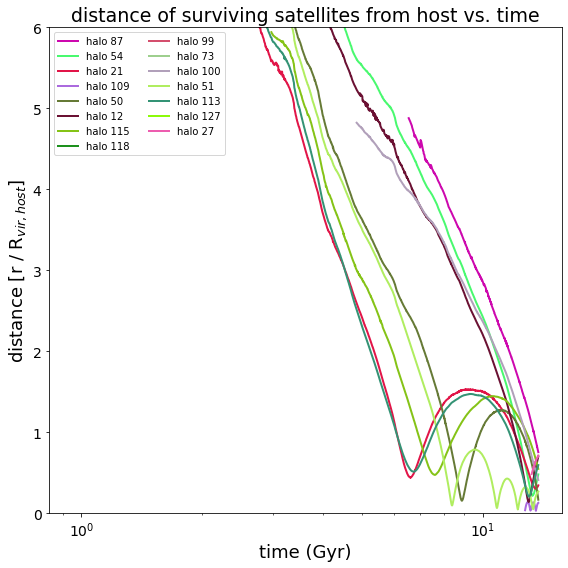

In [7]:
"""
This plots the distance of the surviving satellites 
from the host (Tempest) with respect to time.
"""

fig, ax = plt.subplots(figsize=(8,8))

for i in range(np.size(all_sat_t)):
    plt.plot(all_sat_t[i], all_sat_ratio[i], linewidth=2, c=(r_array[i], b_array[i], g_array[i]), \
            label='halo ' + str(sats[i].halo_number))

plt.legend(loc='upper left', prop={'size': 10}, ncol=2)
plt.title('distance of surviving satellites from host vs. time', fontsize=19)
plt.xlabel('time (Gyr)', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('distance [r / R$_{vir,host}$]', fontsize=18)
plt.yticks(fontsize=14)
plt.ylim(0, 6)
#plt.xlim(2, max(sat_t))
plt.xscale('log')
plt.tight_layout()
plt.style.use('default')
plt.savefig('plots/LDB_satellite_over_time.png')

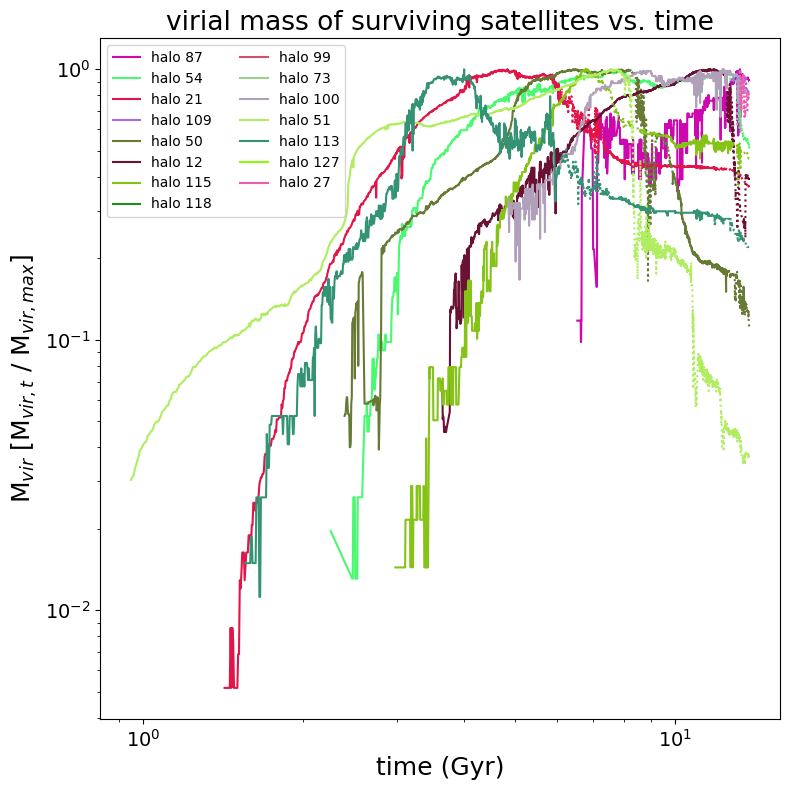

In [8]:
"""
This plots the virial mass of the surviving satellites 
with respect to time.
"""

fig, ax = plt.subplots(figsize=(8,8))

for i in range(np.size(all_sat_t)):
    radius_ratio = all_sat_r[i] / all_host_rvir[i]
    in_rvir = radius_ratio <= 1
    out_rvir = radius_ratio > 1
    plt.plot(all_sat_t[i], np.ma.masked_where(in_rvir, all_sat_mvir_ratio[i]), linestyle='-', \
             c=(r_array[i], b_array[i], g_array[i]), label='halo ' + str(sats[i].halo_number))
    plt.plot(all_sat_t[i], np.ma.masked_where(out_rvir, all_sat_mvir_ratio[i]), linestyle=':', \
             c=(r_array[i], b_array[i], g_array[i]))
    
plt.legend(loc='upper left', prop={'size': 10}, ncol=2)
plt.title('virial mass of surviving satellites vs. time', fontsize=19)
plt.xlabel('time (Gyr)', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('M$_{vir}$ [M$_{vir,t}$ / M$_{vir,max}$]', fontsize=18)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.style.use('default')
plt.savefig('plots/LDB_satellite_mvir_over_time.png')

In [9]:
"""
Next, we investigate if any of the satellites have their peak Mvir
at the first time of appearance in the simulation.
"""

first_time_peak_idx = []
how_many_peaks = 0
for i in range(np.size(all_sat_mvir)):
    if all_sat_mvir[i][0] == max(all_sat_mvir[i]):
        how_many_peaks += 1
        print('halo ' + str(sats[i].halo_number) + \
              ' peaks in Mvir at the first time of appearance; array index: ' + str(i))
        first_time_peak_idx.append(i)

print('\nIn total, ' + str(how_many_peaks) + '/' + str(np.size(all_sat_mvir)) + \
      ' halos peak in Mvir at the first time of appearance.')

halo 118 peaks in Mvir at the first time of appearance; array index: 7
halo 99 peaks in Mvir at the first time of appearance; array index: 8
halo 73 peaks in Mvir at the first time of appearance; array index: 9
halo 127 peaks in Mvir at the first time of appearance; array index: 13

In total, 4/15 halos peak in Mvir at the first time of appearance.


In [10]:
"""
Here, we'll try to find out the time of first in-fall
and the peak Mvir of each of the satellite halos
"""

first_infall = np.zeros(np.size(all_sat_t))

for i in range(np.size(all_sat_t)):
    each_halo = all_sat_t[i]
    radius_ratio = all_sat_r[i] / all_host_rvir[i]
    infalls = each_halo[radius_ratio <= 1]
    if np.size(infalls) == 0:
        first_infall[i] = 0
    else:
        first_infall[i] = min(infalls)
        
with open("Mvir_vs_1st_infall_surviving.txt", "w") as f:
    for idx in range(np.size(all_sat_t)):
        if idx in first_time_peak_idx:
            f.write(str(first_infall[idx]) + ' ' + str(all_sat_mvir_max[idx]) + ' ' + str(1))
            f.write('\n')
        else:
            f.write(str(first_infall[idx]) + ' ' + str(all_sat_mvir_max[idx]) + ' ' + str(0))
            f.write('\n')
        
f.close()
        
print(first_infall, np.size(first_infall))
print(all_sat_mvir_max, np.size(all_sat_mvir_max))

[13.41227214 12.28259844  6.10166949 12.75598551  8.18349673 12.01900791
  6.88706168 13.75931383 13.75931383 13.75931383 12.76674431  7.72624785
  6.10166949 13.75931383 13.24551078] 15
[70805755.39568345 212417266.18705037 1614676258.992806 136058992.8057554
 1699280575.5395684 1310604316.5467627 192978417.26618707
 9718417.266187051 2776690.6474820147 5553381.294964029 99961151.0791367
 6044892086.3309355 372071942.4460432 15271942.446043167
 37484892.086330935] 15


Now, we're using yt to see which of the surviving halos contain stars.

In [20]:
import foggie.utils.foggie_load as fog
import yt
from yt.units.yt_array import YTQuantity, YTArray
from yt.data_objects.particle_filters import add_particle_filter

import LoadSorted

print('ok')

yt : [WARNING  ] 2022-07-19 17:49:52,767 The stars particle filter already exists. Overriding.
yt : [INFO     ] 2022-07-19 17:49:52,867 Parameters: current_time              = 639.44480357087
yt : [INFO     ] 2022-07-19 17:49:52,869 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-19 17:49:52,872 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-19 17:49:52,874 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-19 17:49:52,875 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-19 17:49:52,875 Parameters: current_redshift          = 0
yt : [INFO     ] 2022-07-19 17:49:52,876 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-19 17:49:52,876 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-19 17:49:52,877 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-07-19 17:49:52,878 Parameters: hubble_constant           = 0.695


Opening snapshot /Users/bnguyen/Downloads/DD2427/DD2427
get_refine_box: using this location:         col1          col2     col3     col4    col5     col6     col7  col8
------------------- -------- -------- ------- -------- -------- ------- ----
4.4408920985006e-16 0.488865 0.470316 0.50854 0.490865 0.472316 0.51054    9


Parsing Hierarchy : 100%|█████████████████| 4262/4262 [00:00<00:00, 5903.50it/s]
yt : [INFO     ] 2022-07-19 17:49:53,813 Gathering a field list (this may take a moment.)
yt : [WARNING  ] 2022-07-19 17:49:55,670 The stars particle filter already exists. Overriding.


Pulling halo center from catalog file
filtering young_stars particles...
filtering old_stars particles...
filtering stars particles...
filtering dm particles...
using particle type  young_stars  to derive angular momentum


yt : [WARNING  ] 2022-07-19 17:50:55,837 The Derived Field ('io', 'particle_spherical_position_radius') is deprecated as of yt v4.0.0 and will be removed in yt v4.1.0. Use ('io', 'particle_position_spherical_radius') instead.
yt : [WARNING  ] 2022-07-19 17:50:55,847 The Derived Field ('io', 'particle_spherical_position_theta') is deprecated as of yt v4.0.0 and will be removed in yt v4.1.0. Use ('io', 'particle_position_spherical_theta') instead.
yt : [WARNING  ] 2022-07-19 17:50:55,849 The Derived Field ('io', 'particle_spherical_position_phi') is deprecated as of yt v4.0.0 and will be removed in yt v4.1.0. Use ('io', 'particle_position_spherical_phi') instead.
yt : [WARNING  ] 2022-07-19 17:50:55,853 The Derived Field ('io', 'particle_spherical_velocity_radius') is deprecated as of yt v4.0.0 and will be removed in yt v4.1.0. Use ('io', 'particle_velocity_spherical_radius') instead.
yt : [WARNING  ] 2022-07-19 17:50:55,861 The Derived Field ('io', 'particle_spherical_velocity_theta') i

found angular momentum vector


yt : [WARNING  ] 2022-07-19 17:50:55,959 The Derived Field ('all', 'particle_spherical_velocity_phi') is deprecated as of yt v4.0.0 and will be removed in yt v4.1.0. Use ('all', 'particle_velocity_spherical_phi') instead.
yt : [WARNING  ] 2022-07-19 17:50:55,966 The Derived Field ('all', 'particle_cylindrical_velocity_theta') is deprecated as of yt v4.0.0 and will be removed in yt v4.1.0. Use ('all', 'particle_velocity_cylindrical_theta') instead.
yt : [WARNING  ] 2022-07-19 17:50:55,969 The Derived Field ('all', 'particle_cylindrical_velocity_z') is deprecated as of yt v4.0.0 and will be removed in yt v4.1.0. Use ('all', 'particle_velocity_cylindrical_z') instead.
yt : [WARNING  ] 2022-07-19 17:50:56,013 The Derived Field ('nbody', 'particle_spherical_position_radius') is deprecated as of yt v4.0.0 and will be removed in yt v4.1.0. Use ('nbody', 'particle_position_spherical_radius') instead.
yt : [WARNING  ] 2022-07-19 17:50:56,023 The Derived Field ('nbody', 'particle_spherical_posit

yt : [WARNING  ] 2022-07-19 17:50:56,862 The Derived Field ('old_stars', 'particle_spherical_velocity_theta') is deprecated as of yt v4.0.0 and will be removed in yt v4.1.0. Use ('all', 'particle_velocity_spherical_theta') instead.
yt : [WARNING  ] 2022-07-19 17:50:56,890 The Derived Field ('stars', 'particle_cylindrical_velocity_theta') is deprecated as of yt v4.0.0 and will be removed in yt v4.1.0. Use ('all', 'particle_velocity_cylindrical_theta') instead.
yt : [WARNING  ] 2022-07-19 17:50:56,892 The Derived Field ('stars', 'particle_cylindrical_velocity_z') is deprecated as of yt v4.0.0 and will be removed in yt v4.1.0. Use ('all', 'particle_velocity_cylindrical_z') instead.
yt : [WARNING  ] 2022-07-19 17:50:56,919 The Derived Field ('stars', 'particle_spherical_position_phi') is deprecated as of yt v4.0.0 and will be removed in yt v4.1.0. Use ('all', 'particle_position_spherical_phi') instead.
yt : [WARNING  ] 2022-07-19 17:50:56,921 The Derived Field ('stars', 'particle_spherical

ok


In [21]:
"""
First, we locate all the stars 
in the satellites around Tempest.
"""

halo = 'Tempest'
hnum = '008508'

snap_name = '/Users/bnguyen/Downloads/DD2427/DD2427'
halo_c_v_name = '/Users/bnguyen/FOGGIE/foggie/halo_infos/'+hnum+'/nref11c_nref9f/halo_c_v'
trackname = '/Users/bnguyen/FOGGIE/foggie/halo_tracks/'+hnum+'/nref11n_selfshield_15/halo_track_200kpc_nref9'
masses_dir = '/Users/bnguyen/FOGGIE/foggie/halo_infos/'+hnum+'/nref11c_nref9f/'

def StarParts(pfilter, data):
    return data[("all", "particle_type")] == 2 # only grab star particles

def DMParts(pfilter, data):
    return data[("all", "particle_type")] == 4 # only grab DM particles

add_particle_filter("stars", function=StarParts, filtered_type='all', requires=["particle_type"])
add_particle_filter("DM", function=DMParts, filtered_type='all', requires=["particle_type"])
    
ds, region = fog.foggie_load(snap_name, trackname, find_halo_center=True, halo_c_v_name=halo_c_v_name, disk_relative=False, \
                            particle_type_for_angmom='young_stars', do_filter_particles=False, gravity=False,\
                            region='refine_box',masses_dir=masses_dir)
                            
ds.add_particle_filter('stars')
ds.add_particle_filter('DM')
ads = ds.all_data()

yt : [WARNING  ] 2022-07-19 17:51:38,142 The stars particle filter already exists. Overriding.
yt : [WARNING  ] 2022-07-19 17:51:38,144 The DM particle filter already exists. Overriding.
yt : [INFO     ] 2022-07-19 17:51:38,227 Parameters: current_time              = 639.44480357087
yt : [INFO     ] 2022-07-19 17:51:38,230 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-07-19 17:51:38,233 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-07-19 17:51:38,236 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-07-19 17:51:38,236 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-07-19 17:51:38,237 Parameters: current_redshift          = 0
yt : [INFO     ] 2022-07-19 17:51:38,237 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-07-19 17:51:38,238 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-07-19 17:51:38,239 Parameters: omega_radiation           = 0
yt : [INFO    

Opening snapshot /Users/bnguyen/Downloads/DD2427/DD2427
get_refine_box: using this location:         col1          col2     col3     col4    col5     col6     col7  col8
------------------- -------- -------- ------- -------- -------- ------- ----
4.4408920985006e-16 0.488865 0.470316 0.50854 0.490865 0.472316 0.51054    9


Parsing Hierarchy : 100%|████████████████| 4262/4262 [00:00<00:00, 13609.66it/s]
yt : [INFO     ] 2022-07-19 17:51:38,814 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


In [22]:
"""
Next, we find the center and Rvir of each of the dwarfs in question. 
This helps set up the spherical shells later on.
"""

sat_idx_list = []
rvir_list = []
sat_rvir_list = [] # the difference between this and rvir_list is that this contains only yt quantities
sat_mvir_list = []
sat_cen_list = []

u = 0

while u < np.size(sats):
    
    # this finds the index of each of the satellite halos
    sat_idx = sats[u].halo_number
    
    # this finds the Rvir, Mvir and center positions (in x, y and z) of each of the halos
    sat_rvir = YTQuantity(sim[-1][sat_idx]['Rvir'], 'kpc')
    sat_mvir = YTQuantity(sim[-1][sat_idx]['Mvir'], 'Msun')
    sat_cen = YTArray(sim[-1][sat_idx]['Center']*1000, 'kpc') # converting from Mpc to kpc
    
    sat_idx_list.append(sat_idx)
    sat_rvir_list.append(sat_rvir)
    sat_mvir_list.append(sat_mvir)
    sat_cen_list.append(sat_cen)
    
    print(sat_idx, sat_rvir, sat_mvir, sat_cen)
    u += 1

87 10.470503597122303 kpc 63864748.20143885 Msun [70517.20863309 67753.15107914 73175.43884892] kpc
54 12.4863309352518 kpc 108292086.33093525 Msun [70432.48920863 67722.8057554  73281.95683453] kpc
21 22.056115107913673 kpc 596992805.7553958 Msun [70531.61151079 67764.89208633 73280.83453237] kpc
109 12.643165467625902 kpc 112456115.10791367 Msun [70473.4676259  67774.96402878 73323.79856115] kpc
50 15.064748201438851 kpc 190201438.84892088 Msun [70512.30215827 67784.37410072 73321.48201439] kpc
12 20.95971223021583 kpc 512302158.27338135 Msun [70564.92086331 67684.5323741  73320.33093525] kpc
115 11.749640287769786 kpc 90243165.4676259 Msun [70426.73381295 67711.00719424 73354.70503597] kpc
118 5.589928057553957 kpc 9718417.266187051 Msun [70581.79856115 67717.02158273 73361.41007194] kpc
99 3.682014388489209 kpc 2776690.6474820147 Msun [70481.65467626 67719.72661871 73467.55395683] kpc
73 4.63884892086331 kpc 5553381.294964029 Msun [70647.52517986 67853.98561151 73222.5323741 ] kpc


In [23]:
"""
Now, we go through each of the satellites and get their respective mass profiles.
"""

bin_size = YTQuantity(0.25, 'kpc') # 250 pc is the resolution of the simulation

starless = []
starry = []

starry_rvir = []
starry_mvir = []
starry_cen = []
starry_spheres = []

loc_allstars = []
mass_allstars = []
all_radii = []

for each_halo in range(np.size(sat_idx_list)):
    
    # this goes through each halo to find their Rvir and center position
    each_index = sat_idx_list[each_halo]
    each_rvir = sat_rvir_list[each_halo]
    each_mvir = sat_mvir_list[each_halo]
    each_cen = sat_cen_list[each_halo]
    
    # this uses yt to create spheres which contain the stars of each respective halo
    this_halo = ds.sphere(center=each_cen,radius=each_rvir)
    stars_loc = this_halo['stars','particle_position'].in_units('kpc')
    corrected_stars_loc = stars_loc - each_cen # this places the halo's center as the origin of its stars' coords
    stars_mass = this_halo['stars','particle_mass'].in_units('Msun')
    
    # if the halo in question does not have stars, we save their indices to keep ourselves informed
    if np.size(corrected_stars_loc) == 0:
        starless.append(each_index)
        
    # on the other hand, if the halo does have stars, we construct its mass profile
    else:
        # first, we construct a radius array to work with
        center_position = np.sqrt(np.sum(each_cen ** 2))
        radius_array = np.arange(YTQuantity(0.01, 'kpc'), each_rvir, bin_size)
        
        # next, we add all the relevant star location and mass of the halo
        # to some numpy arrays. this is meant to break down the for loop
        # and help the code run faster.
        loc_allstars.append(corrected_stars_loc)
        mass_allstars.append(stars_mass)
        all_radii.append(radius_array)
        
        # finally, add the rvir and mvir into lists for later analyses
        starry_rvir.append(each_rvir)
        starry_mvir.append(each_mvir)
        starry_cen.append(each_cen)
        starry_spheres.append(this_halo)
        starry.append(each_index)
        
# with everything done, we remove the irrelevant rvir and mvir (irrelevant as in 
# not containing stars) for convenience in the upcoming analyses.
        
sat_idx_array = np.array(sat_idx_list, dtype='object')
starless = np.array(starless, dtype='object')
starry = np.array(starry, dtype='object')

starry_rvir = np.array(starry_rvir, dtype='object')
starry_mvir = np.array(starry_mvir, dtype='object')
starry_cen = YTArray(starry_cen, 'kpc')
starry_spheres = np.array(starry_spheres, dtype='object')

loc_allstars = np.array(loc_allstars, dtype='object')
mass_allstars = np.array(mass_allstars, dtype='object')
all_radii = np.array(all_radii, dtype='object')

print('There are', str(np.size(starless)), 'halos without stars.')
print('There are', str(np.size(starry)), 'halos with stars.')

There are 4 halos without stars.
There are 11 halos with stars.


In [24]:
"""
Next, we construct the 3D distance of ALL the stars in each halo
from the center of said halo. this is to help compute the mass profiles later!
"""

dist_allstars = []

# first, we loop through each halo
for each_halo in loc_allstars:
    
    # this creates a zero np.array so we can later put in the 3D distance of ALL the stars in this halo
    how_many_stars = int(np.size(each_halo) / 3)
    all_stars = np.zeros(how_many_stars)
    print(how_many_stars, 'is the number of stars in this halo.')
    
    idx = 0
    for each_star in each_halo:
        each_star_3d_dist = np.sqrt(np.sum(each_star ** 2))
        all_stars[idx] = each_star_3d_dist # this puts the 3D distance of each star into the zero np.array
        idx += 1       
        
    dist_allstars.append(all_stars)
    
dist_allstars = np.array(dist_allstars, dtype='object')
print(np.shape(dist_allstars))

142 is the number of stars in this halo.
5171 is the number of stars in this halo.
80185 is the number of stars in this halo.
24473 is the number of stars in this halo.
205 is the number of stars in this halo.
104 is the number of stars in this halo.
1 is the number of stars in this halo.
70 is the number of stars in this halo.
145609 is the number of stars in this halo.
2 is the number of stars in this halo.
4 is the number of stars in this halo.
(11,)


In [25]:
"""
Now finally, we construct the mass profile using spherical shells!
"""

all_mass_profiles = []

for i in range(np.size(starry)):
    radius_array = all_radii[i]
    stars_3d_loc = dist_allstars[i]
    stars_mass = mass_allstars[i]
    mvir = starry_mvir[i]
    mass_prof = np.zeros(np.size(radius_array))
    
    h = 0
    for radius_value in radius_array:
        particles_idx = np.where((stars_3d_loc < (YTArray(radius_value, 'kpc') + bin_size)))
        masses_in_here = np.sum(stars_mass[particles_idx])
        mass_prof[h] = masses_in_here
        h += 1
        
    all_mass_profiles.append(mass_prof / np.max(mass_prof))
    
all_mass_profiles = np.array(all_mass_profiles, dtype='object')
print(np.shape(all_mass_profiles))

(11,)


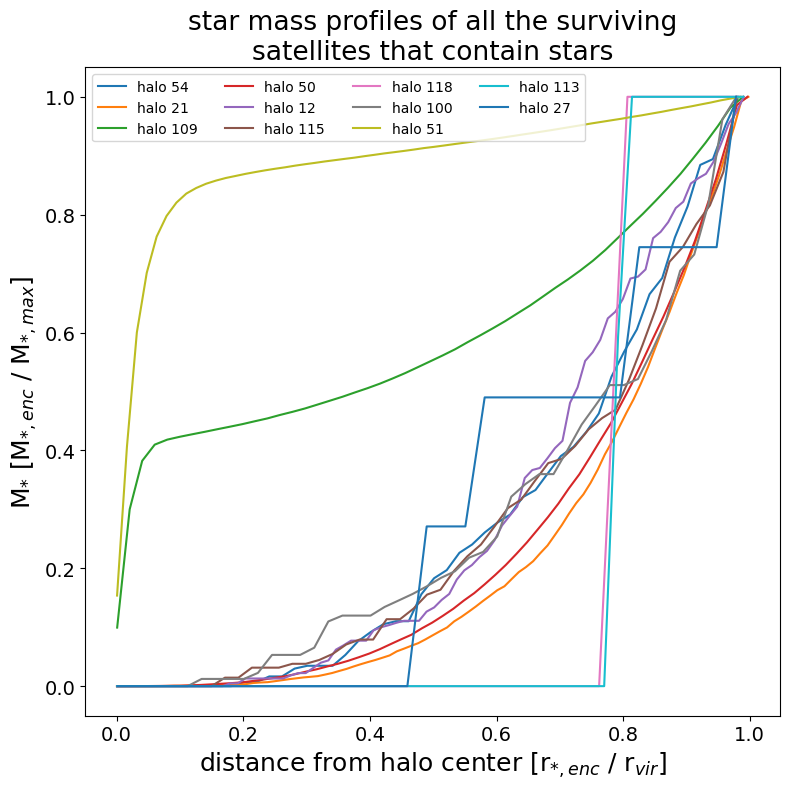

In [26]:
"""
Now, we plot the star mass profiles of all the surviving satellites 
that allegedly contain stars, according to TANGOS' wonderful detection skills.
"""

fig, ax = plt.subplots(figsize=(8,8))

for i in range(np.size(starry)):
    plt.plot(all_radii[i] / starry_rvir[i], all_mass_profiles[i], label='halo ' + str(starry[i]))

plt.legend(loc='upper left', prop={'size': 10}, ncol=4)
plt.title('star mass profiles of all the surviving\nsatellites that contain stars', fontsize=19)
plt.xlabel('distance from halo center [r$_{*,enc}$ / r$_{vir}$]', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('M$_{*}$ [M$_{*,enc}$ / M$_{*,max}$]', fontsize=18)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.style.use('default')
plt.savefig('plots/LDB_star_mass_prof.png')

yt : [INFO     ] 2022-07-19 17:51:52,897 Projection completed
yt : [INFO     ] 2022-07-19 17:51:52,899 xlim = 67716.562590 67729.048921
yt : [INFO     ] 2022-07-19 17:51:52,900 ylim = 73275.713669 73288.200000
yt : [INFO     ] 2022-07-19 17:51:52,901 xlim = 0.470630 0.470717
yt : [INFO     ] 2022-07-19 17:51:52,904 ylim = 0.509266 0.509353
yt : [INFO     ] 2022-07-19 17:51:52,910 Making a fixed resolution buffer of (('deposit', 'DM_density')) 800 by 800
yt : [WARNING  ] 2022-07-19 17:51:52,944 Plotting ('deposit', 'DM_density'): Both positive and negative values. Min = 0.0 g/cm**2, Max = 0.001924801777458027 g/cm**2.
yt : [WARNING  ] 2022-07-19 17:51:52,945 Switching to symlog colorbar scaling.
yt : [INFO     ] 2022-07-19 17:51:53,523 Projection completed
yt : [INFO     ] 2022-07-19 17:51:53,525 xlim = 67716.562590 67729.048921
yt : [INFO     ] 2022-07-19 17:51:53,527 ylim = 73275.713669 73288.200000
yt : [INFO     ] 2022-07-19 17:51:53,529 xlim = 0.470630 0.470717
yt : [INFO     ] 202

yt : [INFO     ] 2022-07-19 17:52:06,165 xlim = 0.470551 0.470632
yt : [INFO     ] 2022-07-19 17:52:06,165 ylim = 0.509774 0.509856
yt : [INFO     ] 2022-07-19 17:52:06,170 Making a fixed resolution buffer of (('deposit', 'DM_density')) 800 by 800
yt : [WARNING  ] 2022-07-19 17:52:06,192 Plotting ('deposit', 'DM_density'): Both positive and negative values. Min = 0.0 g/cm**2, Max = 0.004090203764609213 g/cm**2.
yt : [WARNING  ] 2022-07-19 17:52:06,193 Switching to symlog colorbar scaling.
yt : [INFO     ] 2022-07-19 17:52:06,505 Projection completed
yt : [INFO     ] 2022-07-19 17:52:06,506 xlim = 67705.132374 67716.882014
yt : [INFO     ] 2022-07-19 17:52:06,507 ylim = 73348.830216 73360.579856
yt : [INFO     ] 2022-07-19 17:52:06,508 xlim = 0.470551 0.470632
yt : [INFO     ] 2022-07-19 17:52:06,509 ylim = 0.509774 0.509856
yt : [INFO     ] 2022-07-19 17:52:06,514 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2022-07-19 17:52:06,742 Projection com

yt : [WARNING  ] 2022-07-19 17:52:15,849 Plotting ('deposit', 'DM_density'): Both positive and negative values. Min = 0.0 g/cm**2, Max = 0.0007218006696261851 g/cm**2.
yt : [WARNING  ] 2022-07-19 17:52:15,850 Switching to symlog colorbar scaling.
yt : [INFO     ] 2022-07-19 17:52:16,868 Projection completed
yt : [INFO     ] 2022-07-19 17:52:16,869 xlim = 67847.200719 67855.389209
yt : [INFO     ] 2022-07-19 17:52:16,870 ylim = 73405.646763 73413.835252
yt : [INFO     ] 2022-07-19 17:52:16,871 xlim = 0.471538 0.471595
yt : [INFO     ] 2022-07-19 17:52:16,872 ylim = 0.510169 0.510226
yt : [INFO     ] 2022-07-19 17:52:16,877 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2022-07-19 17:52:17,125 Projection completed
yt : [INFO     ] 2022-07-19 17:52:17,126 xlim = 67847.200719 67855.389209
yt : [INFO     ] 2022-07-19 17:52:17,126 ylim = 73405.646763 73413.835252
yt : [INFO     ] 2022-07-19 17:52:17,128 xlim = 0.471538 0.471595
yt : [INFO     ] 2022-07-1

success!


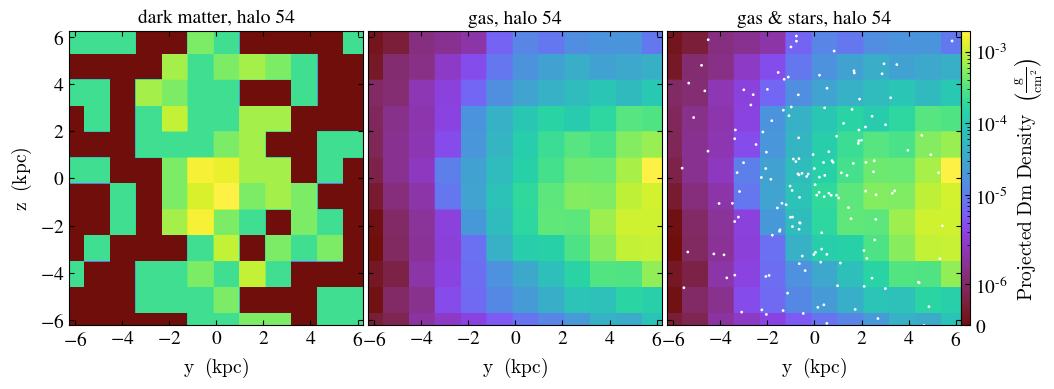

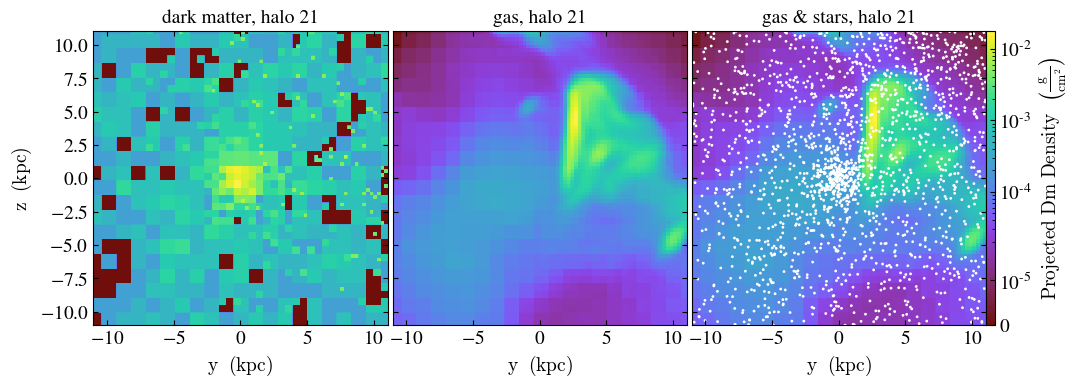

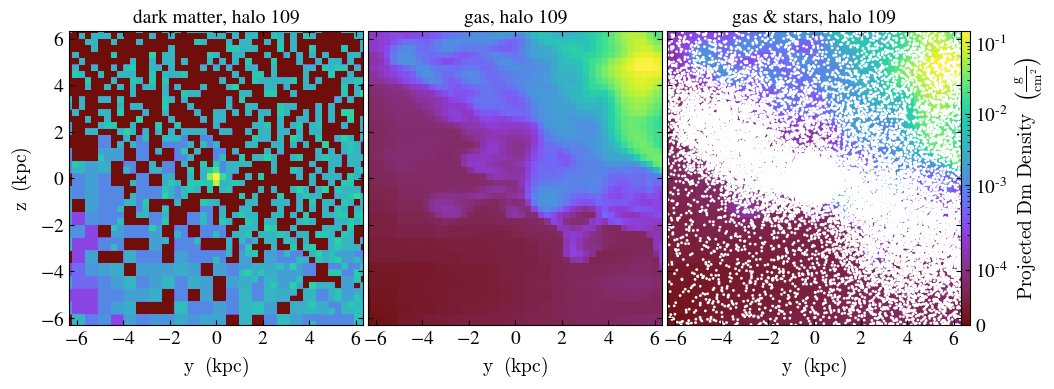

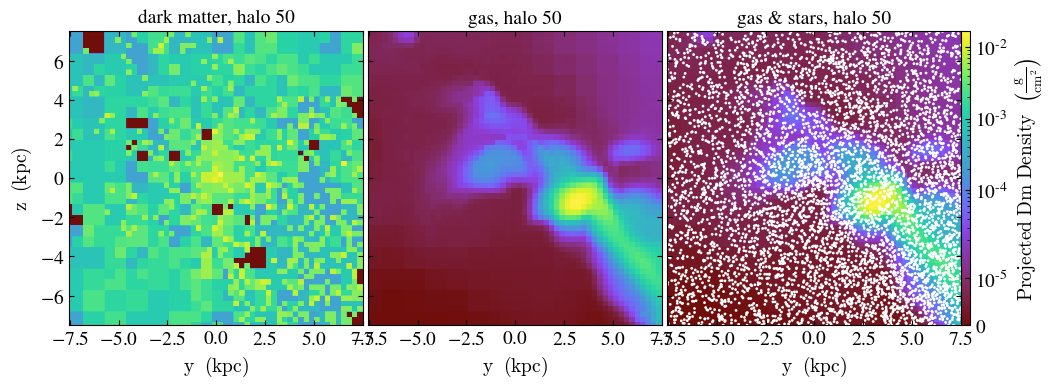

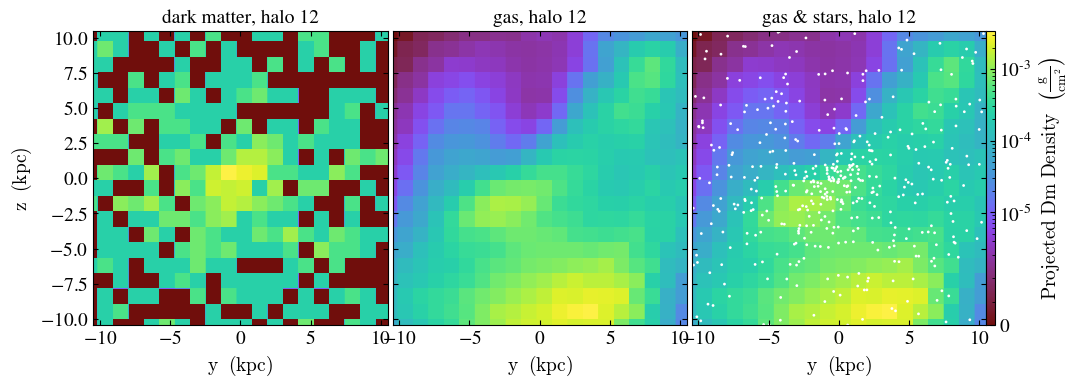

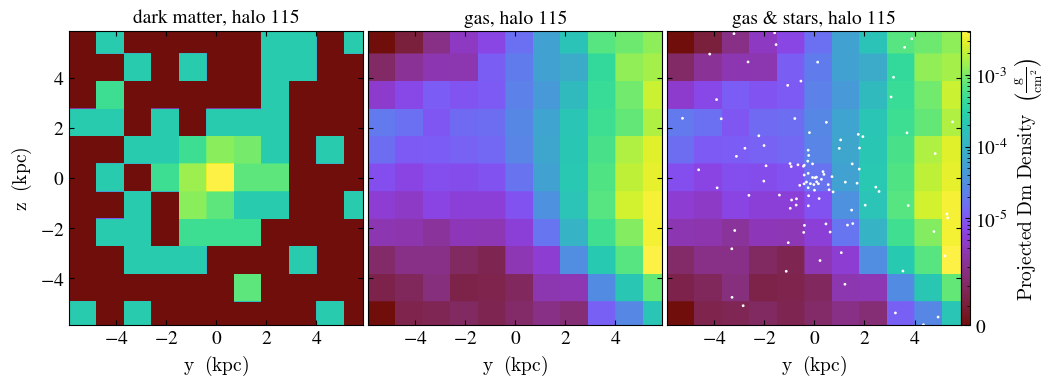

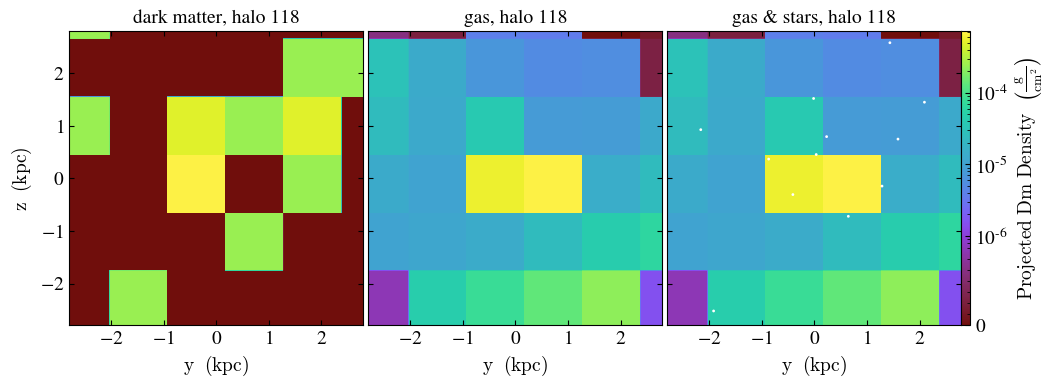

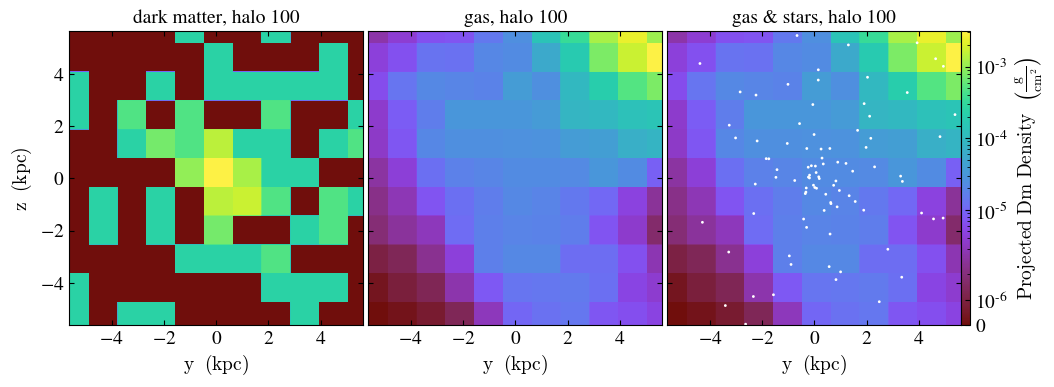

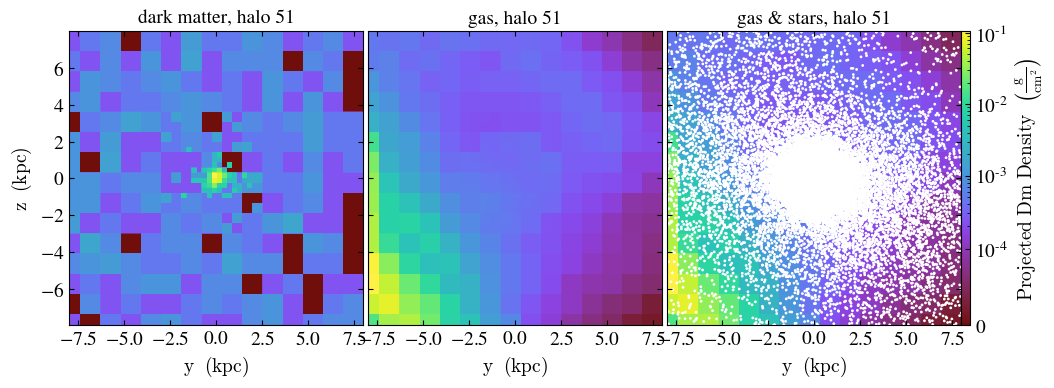

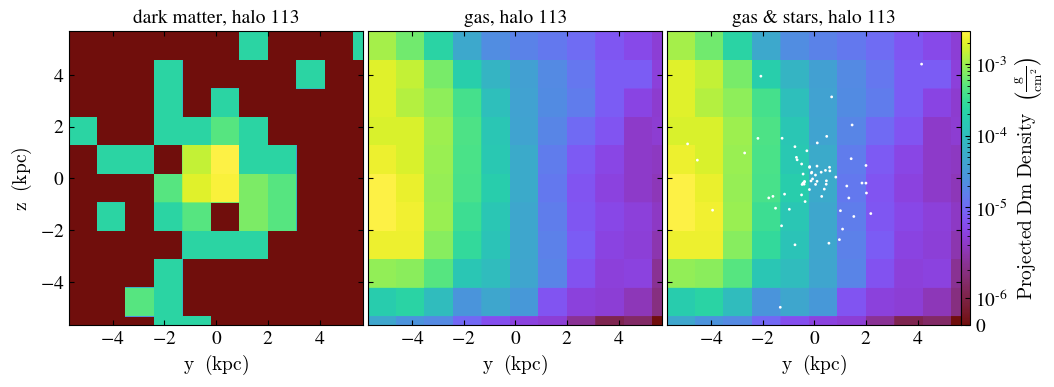

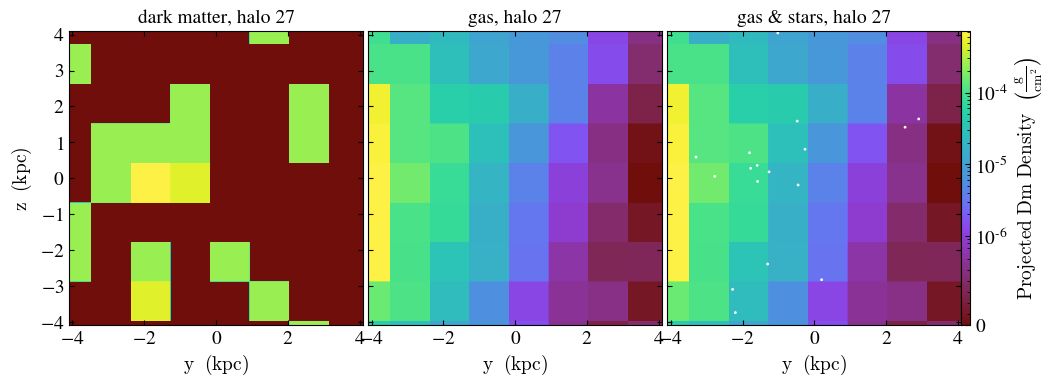

In [27]:
"""
Now, we generate pictures of the surviving halos to see which ones 
can be verifiably called a halo, because TANGOS can be weird.
"""

for idx in range(np.size(starry)):

    fig = plt.figure()
    grid = AxesGrid(
        fig,
        (0.05, 0.05, 0.85, 0.85),
        nrows_ncols=(1, 3),
        axes_pad=0.05,
        label_mode="L",
        share_all=True,
        cbar_location="right",
        cbar_mode="single",
        cbar_size="3%",
        cbar_pad="0%"
    )

    fields = [
        ("deposit", "DM_density"),
        ("gas", "density"),
        ("gas", "density"),
    ]
    
    subtitles=['dark matter', 'gas', 'gas & stars']

    for i, fields in enumerate(fields):
        # Load the data and create a single plot
        p = yt.ProjectionPlot(ds, "x", fields, center=starry_cen[idx], \
                              width=starry_rvir[idx], data_source=starry_spheres[idx], fontsize=14)

        # This forces the ProjectionPlot to redraw itself on the AxesGrid axes.
        plot = p.plots[fields]
        plot.figure = fig
        plot.axes = grid[i].axes
        plot.cax = grid.cbar_axes[i]
        p.annotate_title(subtitles[i] + ', halo ' + str(starry[idx]))
        p.set_minorticks("all", False)
        if i == 2:
            p.annotate_particles(starry_rvir[idx], marker='o', col='white', p_size=4) 

        # Finally, this actually redraws the plot.
        p._setup_plots()

    file_name = 'plots/projections/LDB_' + str(starry[idx]) + '.png'
    plt.savefig(file_name, bbox_inches='tight')
    
print('success!')

In [28]:
"""
Now, we'll compare all the stars in these halos to see which ones didn't 
ACTUALLY belong to the halos and are in fact Tempest's stars
"""

# First, read in the file that contains data on every star in Tempest's stellar halo at z=0
f = h5py.File('/Users/bnguyen/Downloads/Tempest_RD0042_allhalostardata.h5','r')
ptids = f['particle_IDs'][:] # particle index of star - constant across simulation (int)
hids = f['host_IDs'].asstr()[:] # unique ID of halo in which star forms (string, constant across simulation)
ct = f['particle_creation_times'][:] # time at which star was formed (float, Gyr)
Tempest_stars = YTArray(ptids, 'dimensionless')

For halo 54, 142 of its 142 stars are actually Tempest's. 0 are domestic.
For halo 21, 5171 of its 5171 stars are actually Tempest's. 0 are domestic.
For halo 109, 77855 of its 80185 stars are actually Tempest's. 2330 are domestic.
For halo 50, 22954 of its 24473 stars are actually Tempest's. 1519 are domestic.
For halo 12, 205 of its 205 stars are actually Tempest's. 0 are domestic.
For halo 115, 104 of its 104 stars are actually Tempest's. 0 are domestic.
For halo 118, 1 of its 1 stars are actually Tempest's. 0 are domestic.
For halo 100, 70 of its 70 stars are actually Tempest's. 0 are domestic.
For halo 51, 145606 of its 145609 stars are actually Tempest's. 3 are domestic.
For halo 113, 2 of its 2 stars are actually Tempest's. 0 are domestic.
For halo 27, 4 of its 4 stars are actually Tempest's. 0 are domestic.


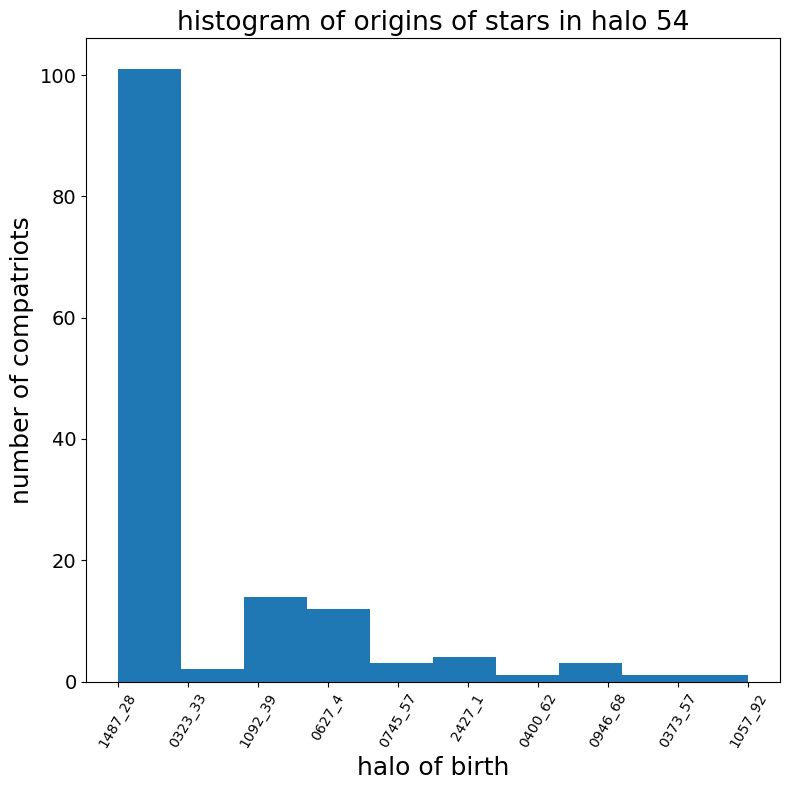

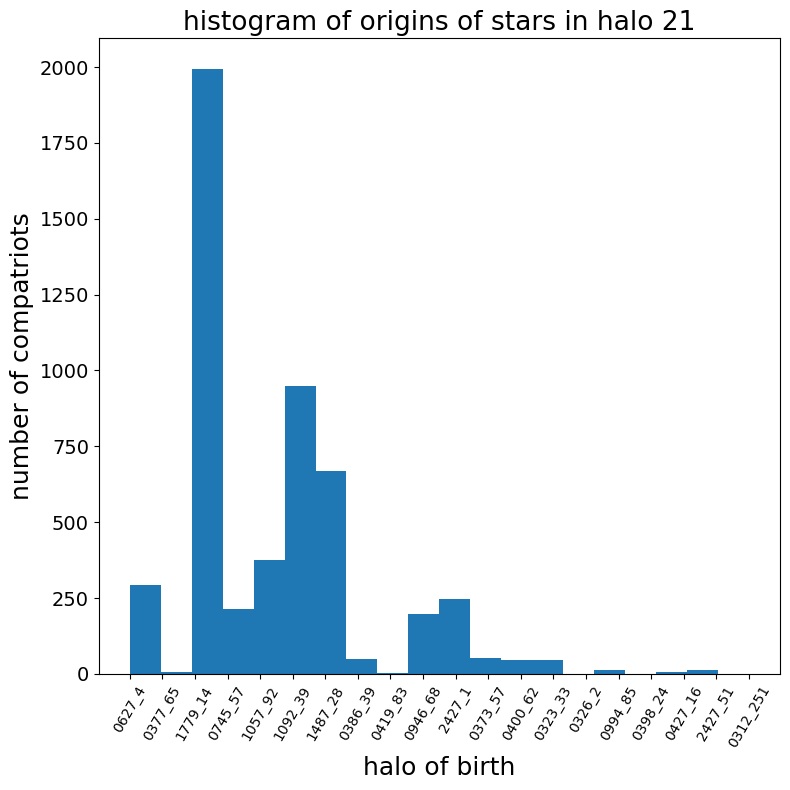

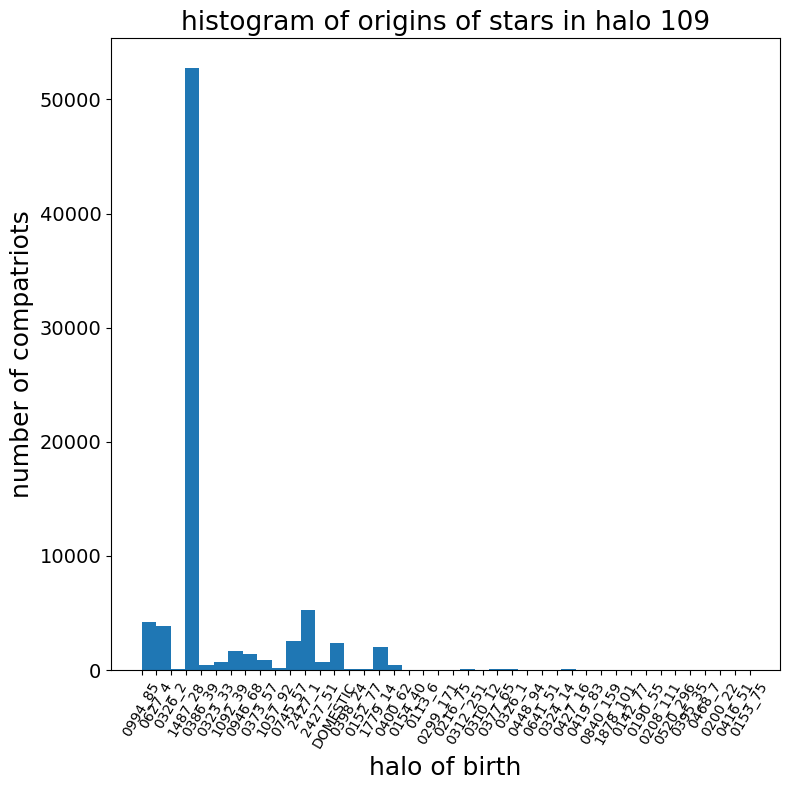

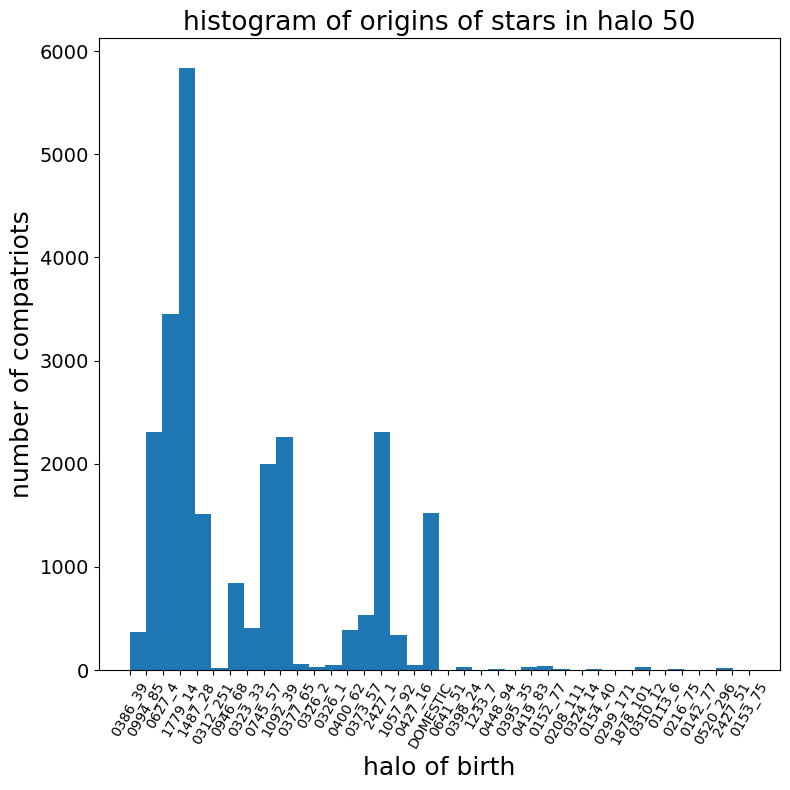

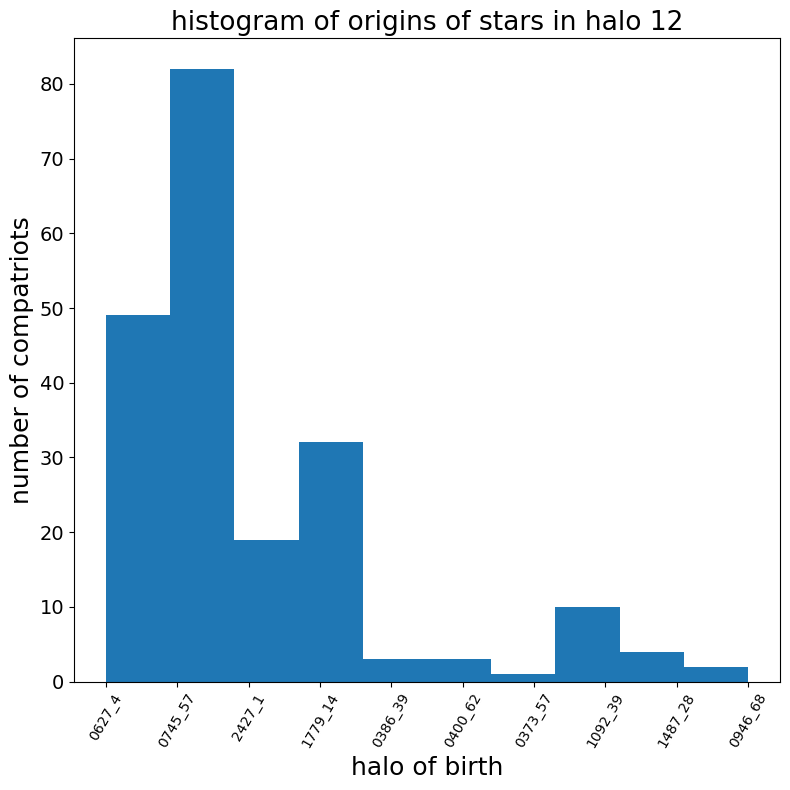

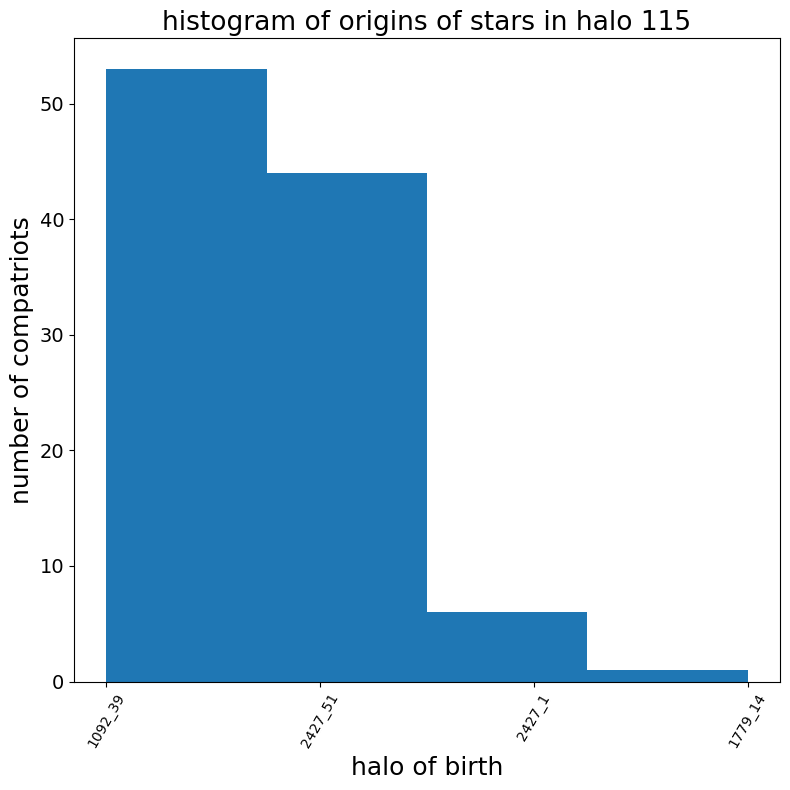

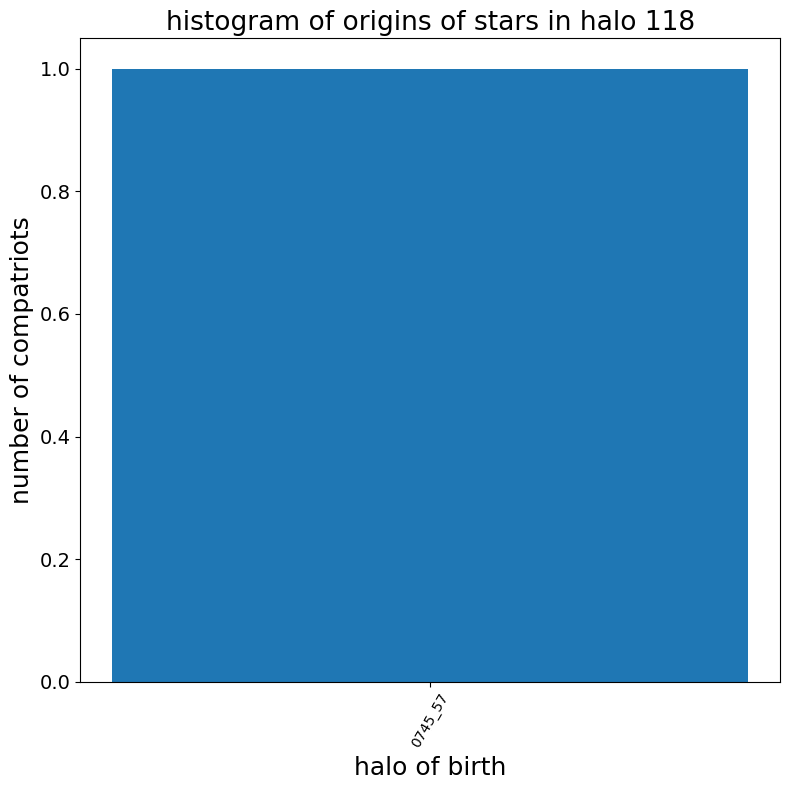

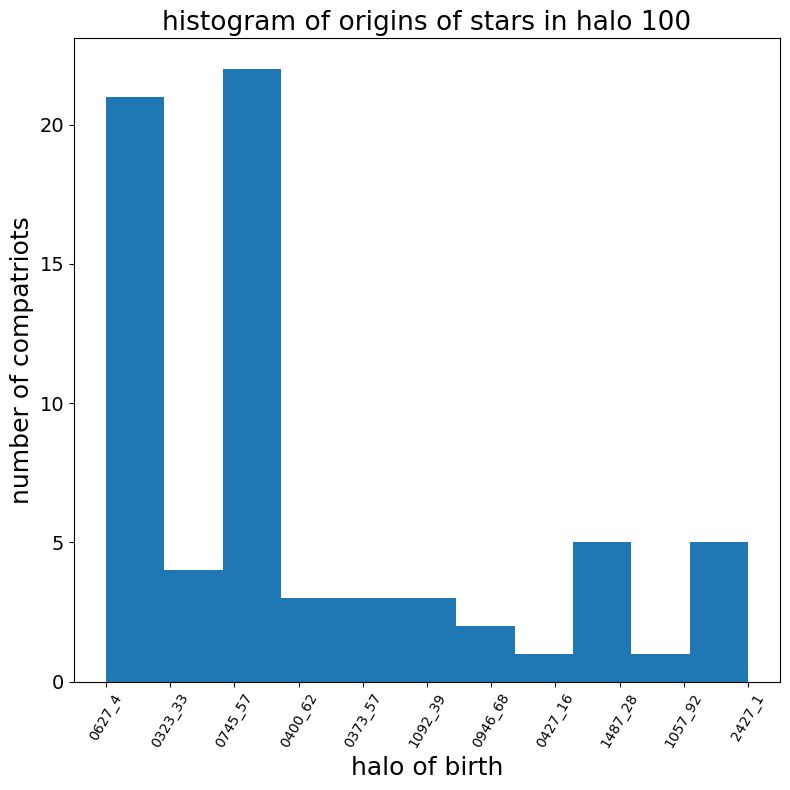

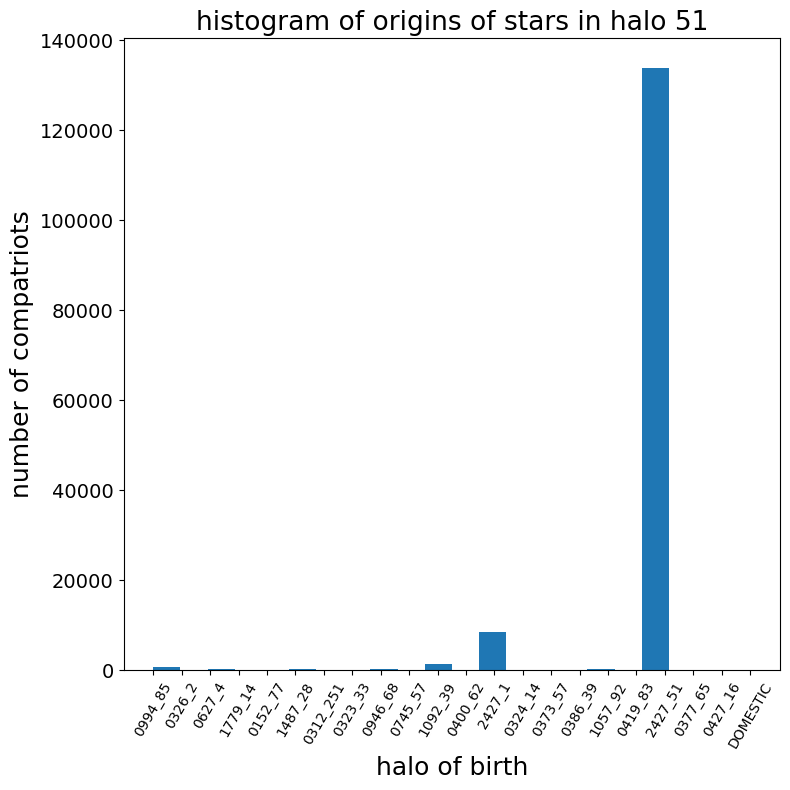

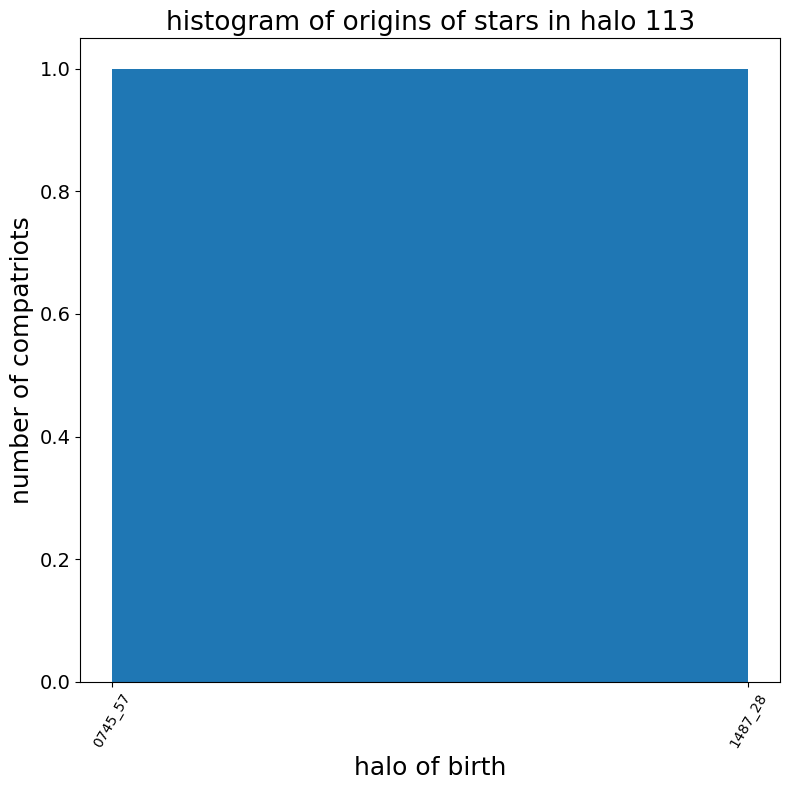

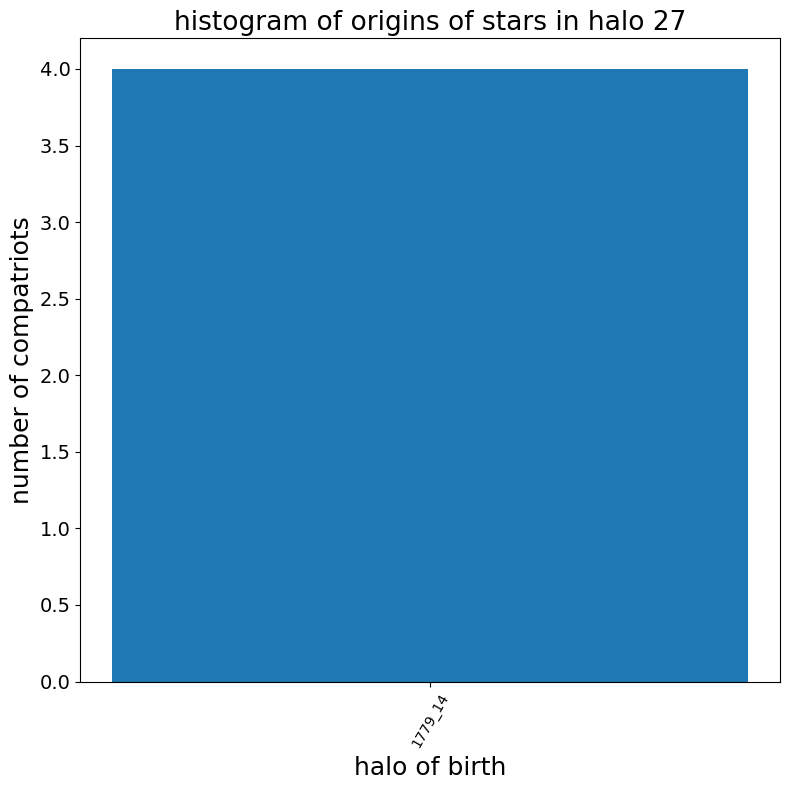

In [29]:
"""
Next, find the origins of all the stars in these halos. The "foreign-born" stars from Tempest
are called visaholders, while the "domestic" ones that are born within these halos 
are referred to as residents.
"""

for idx in range(np.size(starry)):

    this_halo = starry_spheres[idx]
    population = this_halo['stars','particle_index']
    visaholders = np.array([])
    halo_of_birth = np.array([])

    for star in population:
        if star in Tempest_stars:
            visaholders = np.append(visaholders, star)
            halo_of_birth = np.append(halo_of_birth, hids[Tempest_stars == star])
        else:
            halo_of_birth = np.append(halo_of_birth, 'DOMESTIC')

    fig, ax = plt.subplots(figsize=(8, 8))

    relevant_halos = np.unique(halo_of_birth)
    plt.hist(halo_of_birth, bins=np.size(relevant_halos))
    ax.tick_params('x', rotation=60)

    plt.title('histogram of origins of stars in halo ' + str(starry[idx]), fontsize=19)
    plt.xlabel('halo of birth', fontsize=18)
    plt.xticks(fontsize=10)
    plt.ylabel('number of compatriots', fontsize=18)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.style.use('default')
    plt.savefig('plots/histograms/LDB_ ' + str(starry[idx]) + '.png')

    print('For halo ' + str(starry[idx]) + ', ' + str(np.size(visaholders)) + ' of its ' + \
            str(np.size(population)) + " stars are actually Tempest's. " + \
            str(np.size(population) - np.size(visaholders)) + ' are domestic.')

Comparing the halo images with the histograms, we can conclude that there are only 3 genuine surviving satellites that formed stars: halo 21, halo 51 and halo 109. To do a deep-dive, we will run all the virial mass, distance, etc. analyses on only those 3 halos. 

These analyses will be done in a separate Jupyter Notebook called halos_surviving_stars.